In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor, BaggingRegressor, AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np

In [56]:
df = pd.read_csv("real_estate_PML.csv")
df = df.drop("type_l", axis=1)
df_dummies = pd.get_dummies(df, dtype=float)
df_dummies.arr = df_dummies.arr.astype('float')
df_dummies.head()

,arr,n_pieces,n_chambres,surface_m2,prix,prix_m2,ville_Lyon,ville_Marseille,ville_Paris
0,17.0,3.0,1.0,51.84,535000.0,10320.0,0.0,0.0,1.0
1,15.0,3.0,2.0,40.77,470000.0,11528.0,0.0,0.0,1.0
2,13.0,2.0,1.0,39.00,385000.0,9871.0,0.0,0.0,1.0
3,13.0,2.0,1.0,36.03,383000.0,10630.0,0.0,0.0,1.0
4,10.0,2.0,1.0,40.70,399000.0,9803.0,0.0,0.0,1.0


In [70]:
# Decision tree and KNR with Cross validation adn VotingRegressor
seed = 1
cols = df_dummies.columns
features = [col for col in cols if col not in ['prix_m2', 'prix']]
X = df_dummies[features]
y = df_dummies['prix']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)
knr = KNeighborsRegressor(n_neighbors=5, weights='distance', n_jobs=-1)
dt = DecisionTreeRegressor(max_depth=5, min_samples_leaf=0.025, random_state=seed)
classifiers = [('Decision Tree Regressor', dt),
         ('KNeighbors Regressor', knr)]
vtr = VotingRegressor(classifiers, n_jobs=-1)
vtr.fit(X_train, y_train)
cv_score = cross_val_score(vtr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse = (-cv_score.mean())**0.5
print(f"Voting Regressor RMSE: {rmse}")

Voting Regressor RMSE: 395371.845316604


In [95]:
# Bagging with OOB
dtr = DecisionTreeRegressor(max_depth=4, min_samples_leaf=0.025, random_state=seed)
bgr = BaggingRegressor(estimator=knr, n_estimators=400, oob_score=True, n_jobs=-1)
bgr.fit(X_train, y_train)
bgr_scores = cross_val_score(bgr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
bgr_rmse = (-bgr_scores.mean())**0.5
oob_rmse = mean_squared_error(y_train, bgr.oob_prediction_, squared=False)
print(f"Bagging Regressor RMSE: {bgr_rmse} \nOOB RMSE: {oob_rmse}")

Bagging Regressor RMSE: 430496.3732085637 
OOB RMSE: 412830.7628838014


In [80]:
# Random forest Regressor
rf = RandomForestRegressor(n_estimators=500, min_samples_leaf=0.025, random_state=seed, n_jobs=-1)
rf.fit(X_train, y_train)
rf_cv_score = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rf_rmse = (-rf_cv_score.mean())**0.5
print(f"Random Forest RMSE: {rf_rmse}")

Random Forest RMSE: 433864.78280847316


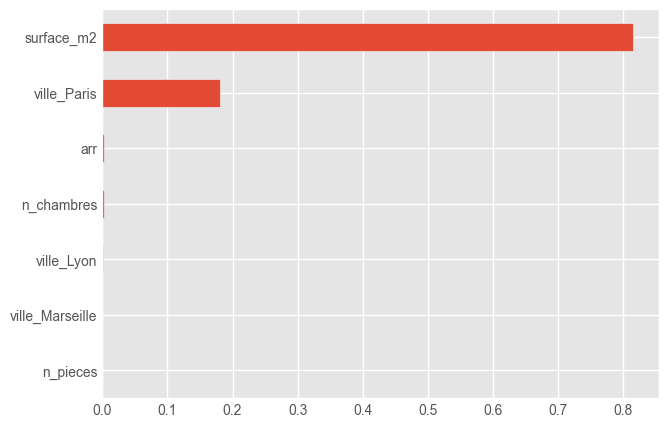

In [92]:
# RF feature importance
style.use('ggplot')
feat_imp = pd.Series(rf.feature_importances_, index = X.columns)
feat_imp_sorted = feat_imp.sort_values()
feat_imp_sorted.plot(kind='barh')
plt.show()

In [98]:
# Adaptive Boosting
base_estimators = [dt, rf]
rmse_scores = []
for estimator in base_estimators:
    adb_reg = AdaBoostRegressor(estimator=estimator, n_estimators=100)
    adb_reg.fit(X_train, y_train)
    ada_cv_scores = cross_val_score(adb_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores.append((str(estimator), (-ada_cv_scores.mean())**0.5))

[('DecisionTreeRegressor(max_depth=5, min_samples_leaf=0.025, random_state=1)',
  473864.7372093636),
 ('RandomForestRegressor(min_samples_leaf=0.025, n_estimators=500, n_jobs=-1,\n                      random_state=1)',
  381129.0820066382)]

In [99]:
print(f"Random Forest Regressor Ada Boosting RMSE: {rmse_scores[1][1]}")
print(f"Decision Tree Regressor Ada Boosting RMSE: {rmse_scores[0][1]}")

Random Forest Regressor Ada Boosting RMSE: 473864.7372093636


In [112]:
# Gradient Boosting
gbt = GradientBoostingRegressor(n_estimators=400, max_depth=4, random_state=seed)
gbt.fit(X_train, y_train)
gbt_cv_scores = cross_val_score(gbt, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Gradient Boosting Regressor RMSE: {(-gbt_cv_scores.mean())**0.5}")

Gradient Boosting Regressor RMSE: 314142.2411987001


In [114]:
# Stochastic Gradient Boosting
sgbt = GradientBoostingRegressor(max_depth=4, subsample=0.8, max_features=0.25, n_estimators=400, random_state=seed)
sgbt.fit(X_train, y_train)
sgbt_cv_scores = cross_val_score(sgbt, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Stochastic Gradient Boosting Regressor RMSE: {(-sgbt_cv_scores.mean())**0.5}")

Gradient Boosting Regressor RMSE: 309286.0486643204


In [117]:
# Inspect hyperparams
gbt.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'n_iter_no_change': None,
 'random_state': 1,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [131]:
params_gb = {'alpha':list(np.arange(0, 0.91, 0.15)),
             'loss':['quantile','huber'],
             'learning_rate':list(np.arange(0.01, 0.2, 0.05)),
             'n_estimators':[200,300,400,500],
             'subsample':[0.5, 0.75],
             'max_depth':list(np.arange(1,7,1)),
             'max_features':[0.2, 0.4, 0.6]}
sbgt = GradientBoostingRegressor(random_state=seed)
grid_sbgt = RandomizedSearchCV(estimator=sbgt, param_distributions=params_gb,
                       cv=3, scoring='neg_mean_squared_error',
                       verbose=1, n_jobs=-1, n_iter=250)
grid_sbgt.fit(X_train, y_train)
best_hyperparams = grid_sbgt.best_params_

Fitting 3 folds for each of 250 candidates, totalling 750 fits


C:\NKT\IA\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
99 fits failed out of a total of 750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
99 fits failed with the following error:
Traceback (most recent call last):
  File "C:\NKT\IA\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\NKT\IA\lib\site-packages\sklearn\ensemble\_gb.py", line 420, in fit
    self._validate_params()
  File "C:\NKT\IA\lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "C:\NKT\IA\lib\site-packages\sklearn\utils\_param_validation.py", line 97, in validate_parameter_constrai

In [124]:
best_hyperparams

{'subsample': 0.75,
 'n_estimators': 300,
 'max_features': 0.6,
 'max_depth': 6,
 'loss': 'quantile',
 'learning_rate': 0.060000000000000005,
 'alpha': 0.6}

In [137]:
best_sbgt_model = grid_sbgt.best_estimator_
bm_scores = cross_val_score(best_sbgt_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Tuned SGBT RMSE: {(-bm_scores.mean())**0.5}")

Tuned SGBT RMSE: 304574.68922704563


In [127]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 0.025,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [128]:
# One final hyper parameter tuning of Random Forest, followed by an Adaptive boosting
rf_ = RandomForestRegressor(random_state=seed)
param_rf = {'max_depth':list(np.arange(1,10,1)),
            'n_estimators':list(np.arange(100, 700, 100)),
            'min_samples_leaf':list(np.linspace(0.01, 0.5, num=10)),
            'max_features':[0.2, 0.5, 0.75]}


In [129]:
grid_rf = RandomizedSearchCV(estimator=rf_, param_distributions=param_rf,
                       cv=3, scoring='neg_mean_squared_error',
                       verbose=1, n_jobs=-1, n_iter=250)
grid_rf.fit(X_train, y_train)
best_hyperparams = grid_rf.best_params_

Fitting 3 folds for each of 250 candidates, totalling 750 fits


In [130]:
best_rf_model = grid_rf.best_estimator_

In [135]:
rf_tuned_ada = AdaBoostRegressor(estimator=best_rf_model, n_estimators=250)
rf_tuned_ada.fit(X_train, y_train)
rf_tuned_ada_cv_score = cross_val_score(rf_tuned_ada, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rf_tuned_ada_rmse = np.sqrt(-rf_tuned_ada_cv_score.mean())
print(f"Tuned RF + AdaBoosting RMSE: {rf_tuned_ada_rmse}")

Tuned RF + AdaBoosting RMSE: 327691.83740727935
Tuned RF + AdaBoosting RMSE: 327055.61773161247


In [141]:
# Finally let's test the RMSE on X_test
gbt_y_pred = gbt.predict(X_test)
rf_y_pred = rf_tuned_ada.predict(X_test)
sbgt_y_pred = best_sbgt_model.predict(X_test)
rf_tuned_test_rmse = mean_squared_error(y_test, rf_y_pred, squared=False)
sbgt_test_rmse = mean_squared_error(y_test, sbgt_y_pred, squared=False)
vtr_pred = vtr.predict(X_test)
vtr_rmse = mean_squared_error(y_test, vtr_pred, squared=False)
gbt_rmse = mean_squared_error(y_test, gbt_y_pred, squared=False)
print(f"Random Forest Tuned + ADABOOST RMSE on test sample: {rf_tuned_test_rmse}, \nStochastic Gradient Boosting on test sample RMSE: {sbgt_test_rmse}")
print(f"Voting Regressor RMSE on test sample: {vtr_rmse}")
print(f"Simple Gradient Boosting RMSE on test sample: {gbt_rmse}")

Random Forest Tuned + ADABOOST RMSE on test sample: 336845.45926761744, 
Stochastic Gradient Boosting on test sample RMSE: 288752.53859703895
Voting Regressor RMSE on test sample: 344167.9437913944
Simple Gradient Boosting RMSE on test sample: 282297.3359428547
